In [2]:
#%pip install optuna-integration[lightgbm]

import lightgbm as lgb
import numpy as np
import pandas as pd
import numpy as np
import gc
import os
import optuna
from optuna.integration import LightGBMPruningCallback
import sqlite3

/home/pablo/anaconda3/envs/LaboIII/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gc.collect()
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')

In [4]:
# Abrir el archivo parquet y cargarlo en un DataFrame data/l_vm_completa_train_pendientes.parquet
df_pendientes = pd.read_parquet('./data/l_vm_completa_train_pendientes.parquet', engine='fastparquet')
# Reunir los DataFrames df_full y df_pendientes por PRODUCT_ID, CUSTOMER_ID y PERIODO, agregar las 
# columnas de df_pendientes a df_full
df_full = df_full.merge(df_pendientes, on=['PRODUCT_ID', 'CUSTOMER_ID', 'PERIODO'], how='left', suffixes=('', '_features'))
# Imprimir las columnas de df_full
print("Columnas de df_full después de la unión con df_pendientes:")
print(df_full.columns.tolist())

Columnas de df_full después de la unión con df_pendientes:
['PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'CUSTOMER_ID', 'PRODUCT_ID', 'PLAN_PRECIOS_CUIDADOS', 'CUST_REQUEST_QTY', 'CUST_REQUEST_TN', 'TN', 'STOCK_FINAL', 'MEDIA_MOVIL_3M_CLI_PROD', 'MEDIA_MOVIL_6M_CLI_PROD', 'MEDIA_MOVIL_12M_CLI_PROD', 'DESVIO_MOVIL_3M_CLI_PROD', 'DESVIO_MOVIL_6M_CLI_PROD', 'DESVIO_MOVIL_12M_CLI_PROD', 'MEDIA_MOVIL_3M_PROD', 'MEDIA_MOVIL_6M_PROD', 'MEDIA_MOVIL_12M_PROD', 'DESVIO_MOVIL_3M_PROD', 'DESVIO_MOVIL_6M_PROD', 'DESVIO_MOVIL_12M_PROD', 'MEDIA_MOVIL_3M_CLI', 'MEDIA_MOVIL_6M_CLI', 'MEDIA_MOVIL_12M_CLI', 'DESVIO_MOVIL_3M_CLI', 'DESVIO_MOVIL_6M_CLI', 'DESVIO_MOVIL_12M_CLI', 'TN_LAG_01', 'TN_LAG_02', 'TN_LAG_03', 'TN_LAG_04', 'TN_LAG_05', 'TN_LAG_06', 'TN_LAG_07', 'TN_LAG_08', 'TN_LAG_09', 'TN_LAG_10', 'TN_LAG_11', 'TN_LAG_12', 'TN_LAG_13', 'TN_LAG_14', 'TN_LAG_15', 'CLASE', 'CLASE_DELTA', 'ORDINAL', 'TN_DELTA_01', 'TN_DELTA_02', '

In [5]:
# Agregar a df_full una variable categorica MES_PROBLEMATICO que sea 1 si PERIODO es 201906 o 201908 o 201910, y 0 en caso contrario
df_full['MES_PROBLEMATICO'] = df_full['PERIODO'].apply(lambda x: 1 if x in [201906, 201908, 201910] else 0)

In [6]:
# Optimizar tipos de datos numéricos
for col in df_full.select_dtypes(include=['int64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='integer')
for col in df_full.select_dtypes(include=['float64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='float')
# Variables categóricas
# categorical_features = ['ANIO','MES','TRIMESTRE','ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','SKU_SIZE','CUSTOMER_ID','PRODUCT_ID','PLAN_PRECIOS_CUIDADOS']
categorical_features = ['ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','PLAN_PRECIOS_CUIDADOS','MES_PROBLEMATICO','A_PREDECIR']
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_full[col] = df_full[col].astype('category')

In [7]:
# Variables predictoras y objetivo
# filtrar que en X el periodo sea menor o igual a 201910
# En x eliminar la columna 'CLASE' y 'CLASE_DELTA'
X = df_full[df_full['PERIODO'] <= 201910].drop(columns=['CLASE', 'CLASE_DELTA']) 
# Filtrar en y que el periodo sea menor o igual a 201910
y = df_full[df_full['PERIODO'] <= 201910]['CLASE_DELTA']
# Eliminar df_full para liberar memoria
del df_full
gc.collect()

0

In [8]:
# Definir los periodos de validación 201910
#periodos_valid = [201910]
periodos_valid = [201910]

# Separar train y cinco conjuntos de validación respetando la secuencia temporal
X_train = X[X['PERIODO'] < periodos_valid[0]]
y_train = y[X['PERIODO'] < periodos_valid[0]]
X_val_list = [X[X['PERIODO'] == p] for p in periodos_valid]
y_val_list = [y[X['PERIODO'] == p] for p in periodos_valid]
del X, y
gc.collect()

0

In [ ]:
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
import os

# === Usamos solo el primer período de validación ===
X_val = X_val_list[0]
y_val = y_val_list[0]

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',  # alias de l1
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 31, 1024, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 24),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'verbose': -1,
        'feature_pre_filter': False,
        'bagging_seed': 42,
        'feature_fraction_seed': 42
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],  # No usar valid_names
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100),
            LightGBMPruningCallback(trial, 'l1')  # Este es el nombre correcto
        ]
    )

    best_score = model.best_score['valid_0']['l1']
    print(f"Trial {trial.number}: MAE = {best_score:.5f}")
    return best_score

# Optuna
storage_url = "sqlite:///./modelos/optuna.db"
study = optuna.create_study(
    direction='minimize',
    study_name="mae_delta_lgbm_regression_todos_los_productos_con_pendientes",
    storage=storage_url,
    load_if_exists=True
)
study.optimize(objective, n_trials=200, show_progress_bar=True)

# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(study.best_params)

# Entrenamiento final
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'mae'
best_params['verbose'] = -1

model_reg = lgb.train(
    best_params,
    train_data,
    num_boost_round=50000,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=500),
        lgb.log_evaluation(period=500)
    ]
)

os.makedirs('./modelos', exist_ok=True)
model_reg.save_model('./modelos/lgbm_model_reg_todos_los_productos.txt')



[I 2025-06-14 18:42:47,063] A new study created in RDB with name: mae_delta_lgbm_regression_todos_los_productos_con_pendientes
  0%|          | 0/200 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.0515186
[200]	valid_0's l1: 0.0505963
[300]	valid_0's l1: 0.0505651


Best trial: 0. Best value: 0.0505087:   0%|          | 1/200 [02:08<7:07:47, 128.98s/it]

Early stopping, best iteration is:
[234]	valid_0's l1: 0.0505087
Trial 0: MAE = 0.05051
[I 2025-06-14 18:44:56,034] Trial 0 finished with value: 0.05050871987304601 and parameters: {'num_leaves': 120, 'learning_rate': 0.023077512869434047, 'feature_fraction': 0.938679441652024, 'bagging_fraction': 0.8443070918565925, 'bagging_freq': 5, 'min_data_in_leaf': 314, 'max_depth': 18, 'lambda_l1': 1.8952882351409879, 'lambda_l2': 2.4978171003341645, 'min_gain_to_split': 0.9101372236822849}. Best is trial 0 with value: 0.05050871987304601.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.0565799
[200]	valid_0's l1: 0.054568
[300]	valid_0's l1: 0.0533975
[400]	valid_0's l1: 0.0525815
[500]	valid_0's l1: 0.0520274
[600]	valid_0's l1: 0.0516748
[700]	valid_0's l1: 0.0514514
[800]	valid_0's l1: 0.0512613
[900]	valid_0's l1: 0.0511783
[1000]	valid_0's l1: 0.0510877
[1100]	valid_0's l1: 0.0510351
[1200]	valid_0's l1: 0.0509605
[1300]	valid_0's l1: 0.0509157


Best trial: 0. Best value: 0.0505087:   1%|          | 2/200 [09:20<16:52:01, 306.67s/it]

Early stopping, best iteration is:
[1262]	valid_0's l1: 0.0508975
Trial 1: MAE = 0.05090
[I 2025-06-14 18:52:07,097] Trial 1 finished with value: 0.050897512896883955 and parameters: {'num_leaves': 299, 'learning_rate': 0.004980952458055509, 'feature_fraction': 0.8224379595339399, 'bagging_fraction': 0.7341904427153474, 'bagging_freq': 2, 'min_data_in_leaf': 434, 'max_depth': 9, 'lambda_l1': 3.4010992852757465, 'lambda_l2': 3.1179268414532273, 'min_gain_to_split': 0.32166309691880646}. Best is trial 0 with value: 0.05050871987304601.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.0588058
[200]	valid_0's l1: 0.0575942
[300]	valid_0's l1: 0.0565875
[400]	valid_0's l1: 0.0558129
[500]	valid_0's l1: 0.0551958
[600]	valid_0's l1: 0.0546484
[700]	valid_0's l1: 0.0541989
[800]	valid_0's l1: 0.0538248
[900]	valid_0's l1: 0.0535297
[1000]	valid_0's l1: 0.0532729
[1100]	valid_0's l1: 0.0530293
[1200]	valid_0's l1: 0.0528329
[1300]	valid_0's l1: 0.0526714
[140

Best trial: 0. Best value: 0.0505087:   2%|▏         | 3/200 [18:10<22:21:42, 408.64s/it]

[I 2025-06-14 19:00:57,084] Trial 2 finished with value: 0.05187702866347986 and parameters: {'num_leaves': 811, 'learning_rate': 0.002015940760036153, 'feature_fraction': 0.5079643427664209, 'bagging_fraction': 0.6125958808662131, 'bagging_freq': 9, 'min_data_in_leaf': 265, 'max_depth': 7, 'lambda_l1': 3.3061141655865955, 'lambda_l2': 0.7552739854341961, 'min_gain_to_split': 0.5273655745669532}. Best is trial 0 with value: 0.05050871987304601.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.050352


                    feature     importance
53              TN_DELTA_02  990043.000000
16                       TN  337053.000000
74    PENDIENTE_TENDENCIA_3  262762.000000
79    PENDIENTE_TENDENCIA_6  184569.000000
55              TN_DELTA_04  134924.000000
36                TN_LAG_01  102588.000000
19  MEDIA_MOVIL_6M_CLI_PROD   23531.900391
62              TN_DELTA_11       0.000000
68           ANTIG_PRODUCTO       0.000000
67            ANTIG_CLIENTE       0.000000
66              TN_DELTA_15       0.000000
65              TN_DELTA_14       0.000000
64              TN_DELTA_13       0.000000
63              TN_DELTA_12       0.000000
0                   PERIODO       0.000000
70           MEDIA_PROD_PER       0.000000
61              TN_DELTA_10       0.000000
60              TN_DELTA_09       0.000000
59              TN_DELTA_08       0.000000
58              TN_DELTA_07       0.000000


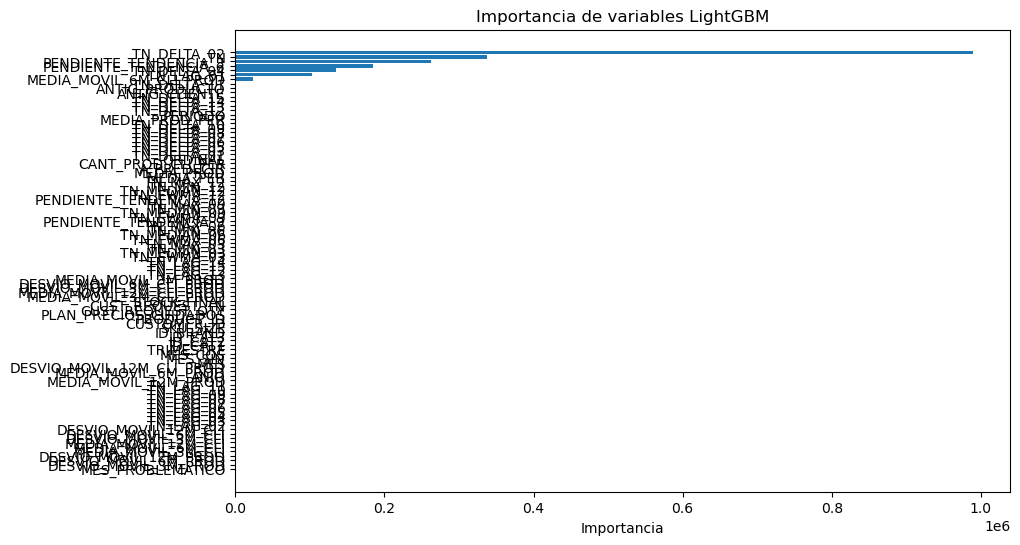

In [36]:
# Obtener la importancia de cada variable
importancia = model_reg.feature_importance(importance_type='gain')
nombres = X_train.columns

# Crear un DataFrame ordenado por importancia
df_importancia = pd.DataFrame({'feature': nombres, 'importance': importancia})
df_importancia = df_importancia.sort_values(by='importance', ascending=False)

# Mostrar las variables más importantes
print(df_importancia.head(20))


# Si quieres visualizarlo gráficamente:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_importancia['feature'], df_importancia['importance'])
plt.gca().invert_yaxis()
plt.title('Importancia de variables LightGBM')
plt.xlabel('Importancia')
plt.show()

In [ ]:
# Cargo los datos sobre los que quiero hacer predicciones

gc.collect()
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')
df_pred_full = df_full[df_full['PERIODO'] == 201910].drop(columns=['CLASE', 'CLASE_DELTA'])
y_obs = df_full[df_full['PERIODO'] == 201910]['CLASE']



In [ ]:
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_pred_full[col] = df_pred_full[col].astype('category')

In [ ]:
# Eliminar del dataframe df_pred_full la columna 'PREDICCIONES'
if 'PREDICCIONES' in df_pred_full.columns:
    df_pred_full.drop(columns=['PREDICCIONES'], inplace=True)

In [ ]:

predictions = model_reg.predict(df_pred_full) 
df_pred_full['PREDICCIONES'] = predictions
# Hacer que las predicciones sean cero si son negativas
df_pred_full['PREDICCIONES'] = np.where(df_pred_full['PREDICCIONES'] < 0, 0, df_pred_full['PREDICCIONES'])
df_pred_full['CLASE'] = y_obs

In [ ]:
# Generar Dataframe que contenga por cada PRODUCT_ID la suma de las predicciones y la suma de la clase observada
df_comp = df_pred_full.groupby('PRODUCT_ID').agg({'PREDICCIONES': 'sum', 'CLASE': 'sum'}).reset_index()
df_comp['DIF_ABS'] = np.abs(df_comp['PREDICCIONES'] - df_comp['CLASE'])
# ordernar por la diferencia absoluta
df_comp = df_comp.sort_values(by='DIF_ABS', ascending=False)
df_comp.head(20)


In [ ]:
# Para los primeros 30 PRODUCT_ID de df_comp generar graficos como el anterior agregando resaltado en el gráfico en el periodo 201912
# el valor PREDICCIONES de DF_COMP para el PRODUCT_ID en el título del gráfico
for product_id in df_comp['PRODUCT_ID'].head(30):
    df_prod = df_full[df_full['PRODUCT_ID'] == product_id].groupby('PERIODO').agg({'TN': 'sum'}).reset_index()
    df_prod['PERIODO'] = df_prod['PERIODO'].astype(str)
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_prod, x='PERIODO', y='TN', marker='o')
    pred_value = df_comp[df_comp["PRODUCT_ID"] == product_id]["PREDICCIONES"].values[0]
    dif = df_comp[df_comp["PRODUCT_ID"] == product_id]["DIF_ABS"].values[0]
    plt.title(f'Evolución de las TN para PRODUCT_ID {product_id} - Predicciones: {pred_value:.2f} - Dif Abs: {dif:.2f}')
    plt.xlabel('Periodo')
    plt.ylabel('Total de TN')
    plt.xticks(rotation=45)
    plt.ylim(0, df_prod['TN'].max() * 1.1)  # Ajustar el eje y para que comience en cero
    plt.scatter('201912', pred_value, color='red', s=100, zorder=5, label='Predicho')
    plt.legend()
    plt.grid()
    plt.show()



In [ ]:
# Generar el DataFrame de salida que contiene PRODUCT_ID y la suma de las predicciones por PRODUCT_ID
df_output = df_pred_full.groupby('PRODUCT_ID')['PREDICCIONES'].sum().reset_index()
# Hacer que la columna de predicciones sea mayor que cero
df_output['PREDICCIONES'] = np.where(df_output['PREDICCIONES'] < 0, 0, df_output['PREDICCIONES'])
df_output.head(10)
# Renombrar las columnas como product_id y tn
df_output.columns = ['product_id', 'tn']
# Guardar el DataFrame de salida en un archivo CSV
df_output.to_csv('./modelos/optuna_lgbm_predictions_sin_val_sin_negativos.csv', index=False)
# Contar los valores negativos en df_output
negativos = df_output[df_output['tn'] < 0].shape[0]
print(f"Número de valores negativos en las predicciones: {negativos}")